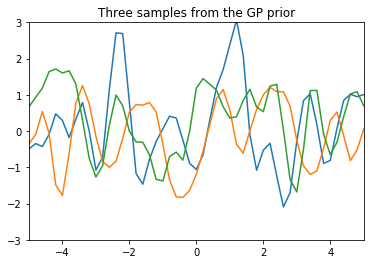

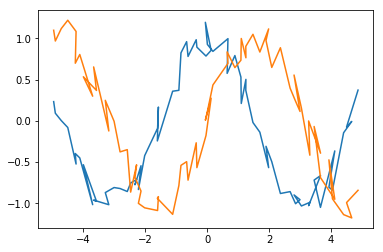

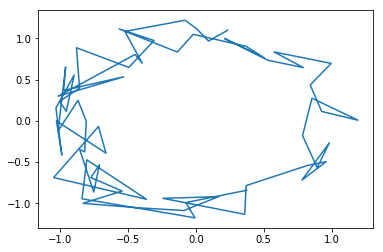

(67, 51)


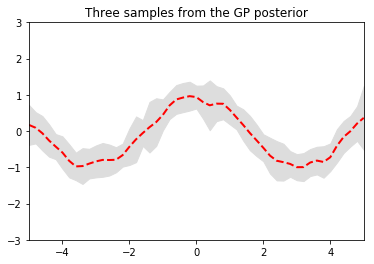

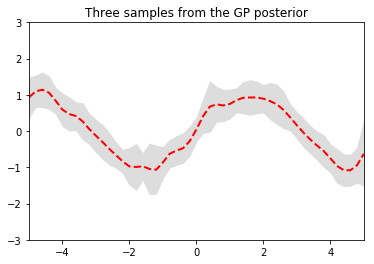

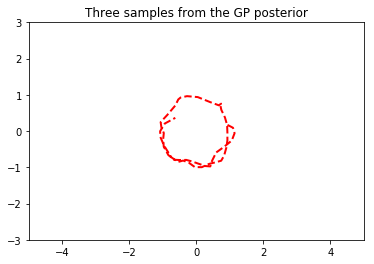

In [2]:
import numpy as np
import matplotlib.pyplot as pl
np.set_printoptions(precision=2,suppress=True)

# Test data
n = 51
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()
ttrain =np.arange(-5,5,0.15) 
ttrain = ttrain + np.random.uniform(-.25,0.25,len(ttrain))
ytrain = np.sin(ttrain)+ np.random.uniform(-.25,0.25,len(ttrain))
xtrain = np.cos(ttrain)+ np.random.uniform(-.25,0.25,len(ttrain))
ttrain = ttrain.reshape(len(ttrain),1)
pl.plot(ttrain,xtrain)
pl.plot(ttrain,ytrain)
pl.show()
pl.plot(xtrain,ytrain)
pl.show()


# Apply the kernel function to our training points
K = kernel(ttrain, ttrain, param)+ 0.1*np.eye(len(ttrain))
L = np.linalg.cholesky(K + 0.00005*np.eye(len(ttrain)))

# Test data
n = 51
ttest = np.linspace(-5, 5, n).reshape(-1,1)

# Compute the mean at our test points.
K_s = kernel(ttrain, ttest, param)
print(K_s.shape)
Lk = np.linalg.solve(L, K_s)
mux = np.dot(Lk.T, np.linalg.solve(L, xtrain)).reshape((n,))
muy = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)





#pl.plot(Xtrain, ytrain, 'bs', ms=8)
#pl.plot(Xtest, f_post)
#pl.plot(ttest, np.sin(Xtest))
pl.gca().fill_between(ttest.flat, mux-2*stdv, mux+2*stdv, color="#dddddd")
pl.plot(ttest, mux, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()
pl.gca().fill_between(ttest.flat, muy-2*stdv, muy+2*stdv, color="#dddddd")
pl.plot(ttest, muy, 'r--', lw=2)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

pl.plot(muy, mux, 'r--', lw=2)
#pl.plot(xtrain,ytrain)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP posterior')
pl.show()

In [3]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (24, 6)
plt = matplotlib.pyplot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


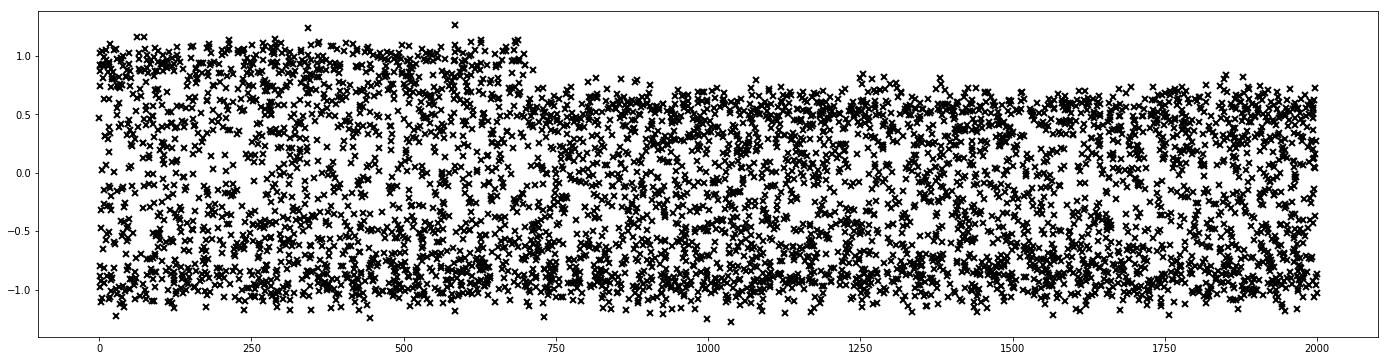

In [30]:
N = 5000
X = 2000*np.random.rand(N,1)
Y = (-0.2/(1+np.exp(-(X-700)*10)))+(1-0.2/(1+np.exp(-(X-700)*10)))*np.sin(4*X) + np.random.randn(N,1)*0.1 
plt.plot(X, Y, 'kx', mew=2)

In [31]:
k1 = gpflow.kernels.Matern52(1, lengthscales=0.3)
k = gpflow.kernels.Periodic(1,period=2.0*3.142, variance=1.0, lengthscales=1.0)
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

/usr/local/lib/python3.6/dist-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


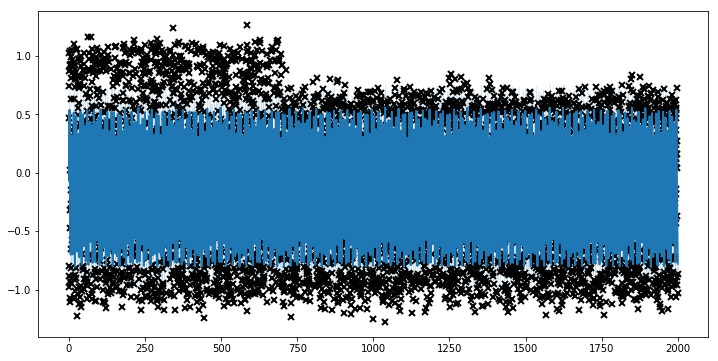

In [32]:
def plot(m):
    xx = np.linspace(-0.1, max(X), 1000).reshape(1000, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    #plt.xlim(-0.1, 10.1)
    
plot(m)

In [46]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/period,Parameter,None,+ve,True,(),True,6.284
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.01


In [ ]:
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
plt.plot(X, Y, 'kx', mew=2)
m.as_pandas_table()

In [14]:
import tensorflow as tf

class Brownian(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(input_dim=1, active_dims=[0])
        self.variance = gpflow.Param(1.0, transform=gpflow.transforms.positive)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        return self.variance * tf.minimum(X, tf.transpose(X2))

    def Kdiag(self, X):
        return self.variance * tf.reshape(X, (-1,))

    
class ChangePoint(gpflow.kernels.Combination):
    def __init__(self, kern_list, offset, variance):
        super(ChangePoint, self).__init__(kern_list)
        self.offset = gpflow.Param(offset)
        self.variance = gpflow.Param(variance)


    def K(self, X, X2=None, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        if X2 is None:
            X2 = X
        XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        XXT2 = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X2, axis=1), tf.expand_dims(X2, axis=2))) + self.offset
        sigm = tf.sigmoid(XXT)
        sigm2 = tf.sigmoid(XXT2)
        sig1 = tf.matmul(tf.expand_dims(sigm, axis=1),
                         tf.expand_dims(sigm2, axis=0))
        sig2 = tf.matmul(tf.expand_dims((1. - sigm), axis=1),
                         tf.expand_dims((1. - sigm2), axis=0))
        a1 = reduce(tf.mul,
                    [sig1, self.kern_list[0].K(X, X2)])
        a2 = reduce(tf.mul,
                    [sig2, self.kern_list[1].K(X, X2)])
        return reduce(tf.add, [a1, a2])


    def Kdiag(self, X, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        sigm = tf.sigmoid(XXT)
        a1 = reduce(tf.mul, [sigm, self.kern_list[0].Kdiag(X),
                             sigm])
        a2 = reduce(tf.mul, [(1. - sigm), self.kern_list[1].Kdiag(X),
                             1. - sigm])
        return reduce(tf.add, [a1, a2])